<a href="https://colab.research.google.com/github/aapoorv-tf/abs-summarizer-using-seq2seq/blob/main/seq2seq_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')
 
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.46.53.234:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.46.53.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.46.53.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
data_more = pd.read_csv("/content/gdrive/MyDrive/IR Project/Dataset/SmallDataset/news_summary_more.csv", encoding='iso-8859-1')
data = pd.read_csv("/content/gdrive/MyDrive/IR Project/Dataset/SmallDataset/news_summary.csv", encoding='iso-8859-1')

In [11]:
df = pd.DataFrame()
df['text'] = pd.concat([data['text'],data_more['text']], ignore_index= True)
df['summary'] = pd.concat([data['headlines'], data_more['headlines']], ignore_index = True)

In [16]:
df.head()

,text,summary
0,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,Daman & Diu revokes mandatory Rakshabandhan in offices order
1,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...",Malaika slams user who trolled her for 'divorcing rich man'
2,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...",'Virgin' now corrected to 'Unmarried' in IGIMS' form
3,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...",Aaj aapne pakad liya: LeT man Dujana before being killed
4,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph...",Hotel staff to get training to spot signs of sex trafficking


In [17]:
import re

def text_strip(column):
    for row in column:
               
        row=re.sub("(\\t)", ' ', str(row)).lower() 
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   
        row=re.sub("(--+)", ' ', str(row)).lower()   
        row=re.sub("(~~+)", ' ', str(row)).lower()   
        row=re.sub("(\+\++)", ' ', str(row)).lower()   
        row=re.sub("(\.\.+)", ' ', str(row)).lower()  
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() 
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower()
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() 
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() 
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower()
        row=re.sub("(\-\s+)", ' ', str(row)).lower() 
        row=re.sub("(\:\s+)", ' ', str(row)).lower() 
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower()
        
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass 
                
        row = re.sub("(\s+)",' ',str(row)).lower()         
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() 
                
        yield row

In [18]:
text = text_strip(df['text'])
summary = text_strip(df['summary'])

In [19]:
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) 
text = [str(doc) for doc in nlp.pipe(text, batch_size=5000, n_threads=-1)]

In [21]:
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(summary, batch_size=5000, n_threads=-1)]

In [22]:
df['cleaned_text'] = pd.Series(text)
df['cleaned_summary'] = pd.Series(summary)

In [23]:
df.head()

,text,summary,cleaned_text,cleaned_summary
0,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,Daman & Diu revokes mandatory Rakshabandhan in offices order,the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august the ad...,_START_ daman diu revokes mandatory rakshabandhan in offices order _END_
1,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...",Malaika slams user who trolled her for 'divorcing rich man',malaika arora slammed an instagram user who trolled her for divorcing rich man and having fun with the alimony her life now is all about wearing short clothes going to gym or salon enjoying vacati...,_START_ malaika slams user who trolled her for divorcing rich man _END_
2,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...",'Virgin' now corrected to 'Unmarried' in IGIMS' form,the indira gandhi institute of medical sciences igims in patna on thursday made corrections in its marital declaration form by changing virgin option to unmarried earlier bihar health minister def...,_START_ virgin now corrected to unmarried in igims form _END_
3,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...",Aaj aapne pakad liya: LeT man Dujana before being killed,lashkar-e-taiba kashmir commander abu dujana who was killed by security forces said kabhi hum aage kabhi aap aaj aapne pakad liya mubarak ho aapko today you caught me congratulations after being c...,_START_ aaj aapne pakad liya let man dujana before being killed _END_
4,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph...",Hotel staff to get training to spot signs of sex trafficking,hotels in maharashtra will train their staff to spot signs of sex trafficking including frequent requests for bed linen changes and do not disturb signs left on room doors for days mobile phone ap...,_START_ hotel staff to get training to spot signs of sex trafficking _END_


In [24]:
wc = pd.DataFrame()
wc['article_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
for i in range(90,100):
  var = wc['article_count'].values
  var = np.sort(var,axis=None)
  print('Word count at {} percentile: {}'.format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile - ",var[-1])

Word count at 90 percentile: 60
Word count at 91 percentile: 60
Word count at 92 percentile: 60
Word count at 93 percentile: 60
Word count at 94 percentile: 60
Word count at 95 percentile: 60
Word count at 96 percentile: 60
Word count at 97 percentile: 61
Word count at 98 percentile: 61
Word count at 99 percentile: 61
100 percentile -  84


In [25]:
wc = pd.DataFrame()
wc['summary_count'] = df['cleaned_summary'].apply(lambda x: len(str(x).split()))
for i in range(90,100):
  var = wc['summary_count'].values
  var = np.sort(var,axis=None)
  print('Word count at {} percentile: {}'.format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile - ",var[-1])

Word count at 90 percentile: 13
Word count at 91 percentile: 13
Word count at 92 percentile: 13
Word count at 93 percentile: 13
Word count at 94 percentile: 14
Word count at 95 percentile: 14
Word count at 96 percentile: 14
Word count at 97 percentile: 14
Word count at 98 percentile: 14
Word count at 99 percentile: 15
100 percentile -  18


In [26]:
max_text_len=60
max_summary_len=15

In [27]:
cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [28]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [29]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.2,random_state=0,shuffle=True)

In [30]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [31]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)

% of rare words in vocabulary: 57.599722140586174


In [32]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc   =  x_tokenizer.num_words + 1

x_voc

31741

In [33]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [34]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)

% of rare words in vocabulary: 66.41434868521053


In [35]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11049


In [36]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [37]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [38]:
from keras import backend as K 

K.clear_session()

latent_dim = 300
embedding_dim=200


def seq2seq():

  global encoder_inputs
  global enc_emb
  global encoder_outputs
  global state_h
  global state_c
  global decoder_inputs
  global dec_emb_layer
  global decoder_lstm
  global decoder_dense

  encoder_inputs = Input(shape=(max_text_len,))

  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  decoder_inputs = Input(shape=(None,))

  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  return model



In [39]:
with tpu_strategy.scope():
  model=seq2seq()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 200)      6348200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 300), (N 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [42]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
622/622 [==============================] - 78s 84ms/step - loss: 5.0741 - val_loss: 4.7413
Epoch 2/50
622/622 [==============================] - 46s 75ms/step - loss: 4.6353 - val_loss: 4.4171
Epoch 3/50
622/622 [==============================] - 47s 75ms/step - loss: 4.3215 - val_loss: 4.1781
Epoch 4/50
622/622 [==============================] - 47s 75ms/step - loss: 4.0954 - val_loss: 3.9978
Epoch 5/50
622/622 [==============================] - 47s 75ms/step - loss: 3.9212 - val_loss: 3.8645
Epoch 6/50
622/622 [==============================] - 47s 75ms/step - loss: 3.7850 - val_loss: 3.7732
Epoch 7/50
622/622 [==============================] - 47s 75ms/step - loss: 3.6722 - val_loss: 3.6920
Epoch 8/50
622/622 [==============================] - 47s 75ms/step - loss: 3.5758 - val_loss: 3.6283
Epoch 9/50
622/622 [==============================] - 47s 75ms/step - loss: 3.4886 - val_loss: 3.5701
Epoch 10/50
622/622 [==============================] - 47s 75ms/step - loss: 3.411

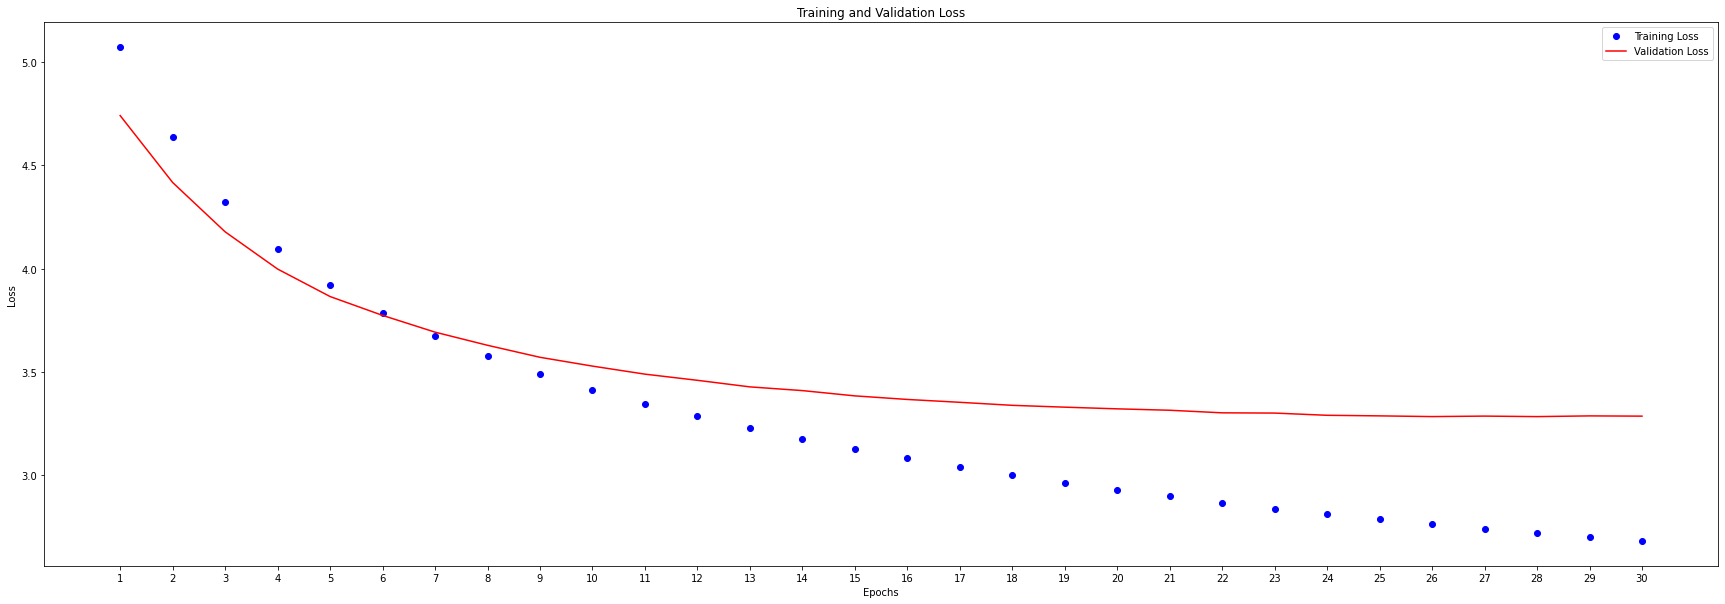

In [45]:
import matplotlib.pyplot as plt

history = model.history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 31)
plt.figure(figsize=(30,10))
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

In [46]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [47]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 
 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [49]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [56]:
for i in range(0,5):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: pope francis on tuesday called for respect for each ethnic group in speech delivered in myanmar avoiding reference to the rohingya minority community as the nation works to restore peace the healing of wounds must be priority he said the pope myanmar visit comes amid the country military crackdown resulting in the rohingya refugee crisis
Original summary: start pope avoids mention of rohingyas in key myanmar speech end
Predicted summary:  start pope urges un to help rohingya muslims end

Review: students of government school in uttar pradesh sambhal were seen washing dishes at in school premises on being approached basic shiksha adhikari virendra pratap singh said yes have also received this complaint from elsewhere we are inquiring and action will be taken against those found guilty 
Original summary: start students seen washing dishes at govt school in up end 
Predicted summary:  start up school students celebrate day with up school end

Review: apple india profit surged by 1

In [57]:
!pip install rouge-score

In [66]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
Rouge1=0
RougeL=0
for i in range(len(x_val)):
  scores = scorer.score(seq2summary(y_val[i]),decode_sequence(x_val[i].reshape(1,max_text_len)))
  Rouge1 += scores['rouge1'][1]
  RougeL += scores['rougeL'][1]

Rouge1 /= len(x_val)
RougeL /= len(x_val)

print("Rouge-1 Score: ",Rouge1)
print("Rouge-L Score: ",RougeL)

Rouge-1 Score:  0.3602442002442003
Rouge-L Score:  0.3369341769341769
